# Exercises Editor
Author: Brent Artuch <br>
Date: 2023-06-07

## Import From SQL

## Introduction

In this notebook we explore how exercise data is logged for a given day of training and calculations to
determine the output of each exercise and what the desired output for the following week will be. The
data entries are recorded at the gym using a simple log app that I developed for Android. The key data
in this notebook will be the `weight` and `reps` of each exercise.

## Step: 1 Imports
### Import packages

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

### Load the dataset
This dataset is pulled from a SQLite database named `exercises` with four tables: `leg_day`, `chest_day`,
`back_day`, and `shoulder_day`. We will load the desired day using a simple query.

In [2]:
sql_connection = sqlite3.connect('exercises.sqlite')
# Import desired table and set the index.
current_exercises = pd.read_sql('SELECT * FROM back_day', sql_connection, index_col='index')
current_exercises.tail(10)

,id,date,name,weight,reps
index,,,,,
26,1000027,2023-05-16 00:00:00,Platform Back Raises,135,16
27,1000028,2023-05-29 00:00:00,Platform Back Raises,135,16
28,1000029,2023-05-29 00:00:00,Straight Arm Pulldown,80,10
29,1000030,2023-05-29 00:00:00,Lat Pulldown,240,10
30,1000031,2023-05-29 00:00:00,Smith Rows,250,13
31,1000032,2023-05-29 00:00:00,High Row Machine,140,10
32,1000033,2023-05-29 00:00:00,Rear Delt Machine,175,13
33,1000034,2023-05-29 00:00:00,Preacher Curl Machine,175,7
34,1000035,2023-05-29 00:00:00,Single Arm Curl,30,8


## Step 2: Data Exploration
Next we will get a sense of the size and contents of `current_exercises`.

In [3]:
current_exercises.shape

(36, 5)

In [4]:
current_exercises.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      36 non-null     int64 
 1   date    36 non-null     object
 2   name    36 non-null     object
 3   weight  36 non-null     int64 
 4   reps    36 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 1.7+ KB


In [5]:
current_exercises['name'].value_counts()

Platform Back Raises     4
Straight Arm Pulldown    4
Lat Pulldown             4
Smith Rows               4
High Row Machine         4
Rear Delt Machine        4
Preacher Curl Machine    4
Single Arm Curl          4
Bicep 21                 4
Name: name, dtype: int64

## Step 3: Update the Dataset
First we will get each of the unique names from `current_exercises`.

In [6]:
# Set names to a list of unique exercise names
names = current_exercises['name'].unique()
names

array(['Platform Back Raises', 'Straight Arm Pulldown', 'Lat Pulldown',
       'Smith Rows', 'High Row Machine', 'Rear Delt Machine',
       'Preacher Curl Machine', 'Single Arm Curl', 'Bicep 21'],
      dtype=object)

Next we set the date that we wish to update.

In [7]:
day_of_month = input("Enter the day of the month: DD")
date = f"2023-06-{day_of_month} 00:00:00"
date

'2023-06-05 00:00:00'

### Execute the entry insertion algorithm

In [8]:
for i in range(0, len(names)):

  """ This algorithm sets the elements of a new entry with user input and then inserts it into the
  database table for each name. Id is calculated by last index."""

  weight = input(f"Enter Weight for {names[i]}: ")
  reps = input(f"Enter Reps for {names[i]}: ")
  e_id = current_exercises.iloc[-1, 0] + 1
  new_entry = [e_id, date, names[i], weight, reps]
  current_exercises.loc[len(current_exercises)] = new_entry

# Format the string dates to datetime.
current_exercises['date'] = pd.to_datetime(current_exercises['date'])
current_exercises.tail(10)

,id,date,name,weight,reps
index,,,,,
35,1000036,2023-05-29,Bicep 21,42,21
36,1000037,2023-06-05,Platform Back Raises,135,17
37,1000038,2023-06-05,Straight Arm Pulldown,80,12
38,1000039,2023-06-05,Lat Pulldown,260,7
39,1000040,2023-06-05,Smith Rows,7,7
40,1000041,2023-06-05,High Row Machine,150,8
41,1000042,2023-06-05,Rear Delt Machine,190,10
42,1000043,2023-06-05,Preacher Curl Machine,140,15
43,1000044,2023-06-05,Single Arm Curl,25,11


### Data Manipulation
This section exists for convenience if quick changes need to be made to the entries.

In [10]:
# Update a single item by id and column
# current_exercises.loc[39, 'weight'] = 290
# Drop last row
# current_exercises.drop(index=current_exercises.index[-1], axis=0, inplace=True)
current_exercises.tail(10)

,id,date,name,weight,reps
index,,,,,
35,1000036,2023-05-29,Bicep 21,42,21
36,1000037,2023-06-05,Platform Back Raises,135,17
37,1000038,2023-06-05,Straight Arm Pulldown,80,12
38,1000039,2023-06-05,Lat Pulldown,260,7
39,1000040,2023-06-05,Smith Rows,290,7
40,1000041,2023-06-05,High Row Machine,150,8
41,1000042,2023-06-05,Rear Delt Machine,190,10
42,1000043,2023-06-05,Preacher Curl Machine,140,15
43,1000044,2023-06-05,Single Arm Curl,25,11


### Update SQL
Now that we have updated our table, we will export the new dataset to SQL. As a precaution, I always
back up the new dataset to CSV through the SQL workbench in the event that an older version is required
in the future.

In [11]:
# Export new chart to database with a date stamp
current_exercises.to_sql('back_day', sql_connection, if_exists='replace')

# TODO: MANUALLY REVIEW AND EXPORT NEW TABLE TO CSV AS BACKUP!!

45

## Step 5: Calculations
Since, I rotate my weights and reps each weak based on performance, we use the volume equation
to determine the rep to weight output.<br>
$Volume$ = `weight` $\cdot$ `reps` $\cdot$ $sets$ <br>
For our purposes the sets parameter will always be 1 because only one working set is performed.

In [14]:
current_exercises['volume'] = current_exercises['weight'].astype(int) * current_exercises['reps'].astype(int)
current_exercises.head()

,id,date,name,weight,reps,volume
index,,,,,,
0,1000001,2023-04-17,Platform Back Raises,135,13,1755
1,1000002,2023-04-17,Straight Arm Pulldown,95,9,855
2,1000003,2023-04-17,Lat Pulldown,260,8,2080
3,1000004,2023-04-17,Smith Rows,290,6,1740
4,1000005,2023-04-17,High Row Machine,130,11,1430


Now we can pull all the `volume` data for analysis of an exercise.

In [18]:
exercise = input("Enter Exercise for Volume Data: ")
exercise_volume = current_exercises[current_exercises['name']==exercise]
print("Mean volume:", exercise_volume['volume'].mean())
exercise_volume

Mean volume:  1833.0


,id,date,name,weight,reps,volume
index,,,,,,
6,1000007,2023-04-17,Preacher Curl Machine,185,8,1480
17,1000018,2023-05-01,Preacher Curl Machine,125,20,2500
23,1000024,2023-05-15,Preacher Curl Machine,155,12,1860
33,1000034,2023-05-29,Preacher Curl Machine,175,7,1225
42,1000043,2023-06-05,Preacher Curl Machine,140,15,2100


## Step 6: Visualization
Next, plot the volume trend for the selected exercise.

<Axes: title={'center': 'Volume Trend Preacher Curl Machine'}, xlabel='Date', ylabel='Volume'>

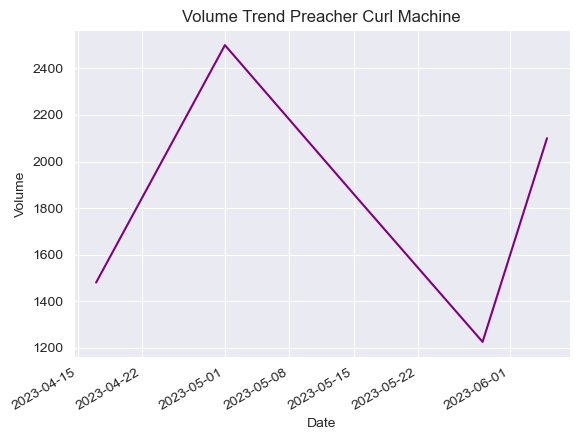

In [19]:
exercise_volume.plot(
  x='date', xlabel= "Date", y='volume', ylabel="Volume", title=f"Volume Trend {exercise}",
  color='purple', legend=False
)

## Leg Day Notes:
* 2023-05-19: Changed Smith Squat range of motion to full so should be marked drop in weight.
* 2023-06-02: Changed Leg Extensions from two legs to one which will account for the weight change.